In [49]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd

In [50]:
class GLCM:

    def __init__(self, srcImage):
        self.BaseImage = np.uint8(srcImage)
        self.rgbImage = cv.cvtColor(self.BaseImage, cv.COLOR_BGR2RGB)
        self.xyzImage = cv.cvtColor(self.BaseImage, cv.COLOR_BGR2XYZ)
        self.labImage = cv.cvtColor(self.BaseImage, cv.COLOR_BGR2LAB)
        self.hlsImage = cv.cvtColor(self.BaseImage, cv.COLOR_BGR2HLS)
        self.hsvImage = cv.cvtColor(self.BaseImage, cv.COLOR_BGR2HSV)

        self.rgbGray = cv.cvtColor(self.rgbImage, cv.COLOR_RGB2GRAY)
        self.xyzGray = self.BaseImage[:, :, 1]
        self.labGray = self.BaseImage[:, :, 0]
        self.hlsGray = self.BaseImage[:, :, 1]
        self.hsvGray = self.BaseImage[:, :, 2]

    def GLCM_horizontal(self, src):
        Operator = src.copy()
        GLCM_HorRight = np.zeros((256, 256))
        h, w = Operator.shape

        for i in range(h):
            for j in range(w - 1):
                get_px = np.array([Operator[i, j], Operator[i, j + 1]])
                GLCM_HorRight[get_px[0], get_px[1]] += 1

        GLCM_HorLeft = np.matrix.transpose(GLCM_HorRight)
        GLCM_HorSym = GLCM_HorRight + GLCM_HorLeft
        return GLCM_HorRight, GLCM_HorLeft, GLCM_HorSym

    def GLCM_vertical(self, src):
        Operator = src.copy()
        GLCM_VertDown = np.zeros((256, 256))
        h, w = Operator.shape

        for i in range(h-1):
            for j in range(w):
                get_px = np.array([Operator[i, j], Operator[i + 1, j]])
                GLCM_VertDown[get_px[0], get_px[1]] += 1

        GLCM_VertUp = np.matrix.transpose(GLCM_VertDown)
        GLCM_VertSym = GLCM_VertDown + GLCM_VertDown
        return GLCM_VertDown, GLCM_VertUp, GLCM_VertSym

    def GLCM_diagonal_LeftToRight_Reverse(self, src):
        Operator = src.copy()
        GLCM_PrimTop_SecDown = np.zeros((256, 256))
        h, w = Operator.shape

        for i in range(h-1):
            for j in range(w-1):
                get_px = np.array([Operator[i,j], Operator[i+1, j+1]])
                GLCM_PrimTop_SecDown[get_px[0], get_px[1]] += 1

        GLCM_PrimDown_SecTop = np.matrix.transpose(GLCM_PrimTop_SecDown)
        GLCM_LeftToRight_Symetric = GLCM_PrimTop_SecDown + GLCM_PrimDown_SecTop
        return GLCM_PrimTop_SecDown, GLCM_PrimDown_SecTop, GLCM_LeftToRight_Symetric
    
    def GLCM_diagonal_RightToLeft_Reverse(self, src):
        Operator = src.copy()
        GLCM_PrimTop_SecDown = np.zeros((256, 256))
        h, w = Operator.shape

        for i in range(h-1):
            for j in range(1, w):
                get_px = np.array([Operator[i,j], Operator[i+1, j-1]])
                GLCM_PrimTop_SecDown[get_px[0], get_px[1]] += 1

        GLCM_PrimDown_SecTop = np.matrix.transpose(GLCM_PrimTop_SecDown)
        GLCM_RightToLeft_Symetric = GLCM_PrimTop_SecDown + GLCM_PrimDown_SecTop
        return GLCM_PrimTop_SecDown, GLCM_PrimDown_SecTop, GLCM_RightToLeft_Symetric


In [51]:
def NormalisedGLCM(GLCM):
    SumOfGLCM = np.sum(GLCM)
    Normalised = np.divide(GLCM, SumOfGLCM)
    return Normalised


def Energy(GLCM):
    PowerOfMatrix = np.power(GLCM, 2)
    SumOfMatrix = np.sum(PowerOfMatrix)
    return SumOfMatrix


def Contrast(GLCM):
    ContrastSum = 0
    for a in range(256):
        for b in range(256):
            ContrastSum += (np.power((a-b), 2) * GLCM[a, b])
    return ContrastSum


def Correlation(GLCM):
    CorrelationSum = 0
    for a in range(256):
        for b in range(256):
            u = np.average(GLCM)
            o = np.std(GLCM)
            CorrelationSum += ((a-u)*(b-u)*GLCM[a, b])
    CorrelationResult = (-1) * CorrelationSum / (np.power(o,2))
    return CorrelationResult


def Variance(GLCM):
    VarianceSum = 0
    u = np.average(GLCM)
    for a in range(256):
        for b in range(256):
            VarianceSum += np.power((a-u), 2)*GLCM[a, b]
    return VarianceSum


def Homogenity(GLCM):
    HomogenitySum = 0
    for a in range(256):
        for b in range(256):
            HomogenitySum += (GLCM[a, b] / (1 + np.power((a-b), 2)))
    return HomogenitySum


def Entropy(GLCM):
    EntropySum = 0
    for a in range(256):
        for b in range(256):
            if (GLCM[a, b] != 0):
                EntropySum += (GLCM[a, b] * np.log(GLCM[a, b]))
    EntropyResult = ((-1) * EntropySum)
    return EntropyResult

(0.0, 1.0, 0.0, 1.0)

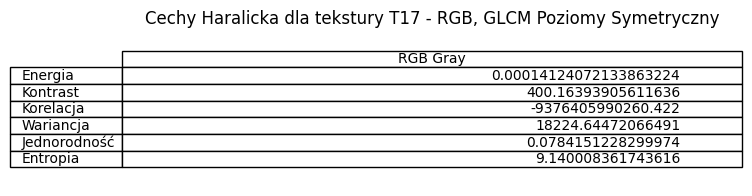

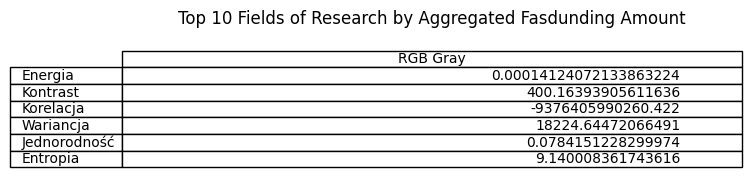

In [52]:
Texture1 = GLCM(cv.imread("./Textures/T17.bmp"))
Texture2 = GLCM(cv.imread("./Textures/T24.bmp"))
Texture3 = GLCM(cv.imread("./Textures/T30.bmp"))

[RGB_T1HorR, RGB_T1HorL, RGB_T1HorSym] = Texture1.GLCM_horizontal(Texture1.rgbGray)
T1RGB_Normalised = NormalisedGLCM(RGB_T1HorSym)
Tex1RGBProps = [Energy(T1RGB_Normalised), Contrast(T1RGB_Normalised), Correlation(T1RGB_Normalised), Variance(T1RGB_Normalised), Homogenity(T1RGB_Normalised), Entropy(T1RGB_Normalised)]

Tex1 = pd.DataFrame({'RGB Gray': Tex1RGBProps})
Tex1.index = ["Energia", "Kontrast", "Korelacja", "Wariancja", "Jednorodność", "Entropia"]


fig = plt.figure(figsize = (8, 2))
ax = fig.add_subplot(111)
ax.table(cellText = Tex1.values, rowLabels = Tex1.index, colLabels = Tex1.columns, loc = "center")
ax.set_title("Cechy Haralicka dla tekstury T17 - GLCM Poziomy Symetryczny")
ax.axis("off")